In [5]:

# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from keras_nlp.layers import PositionEmbedding, SinePositionEncoding 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Define the path to the data
data_path = "Data/"
# Get a list of all directories in the data path
folders = [os.path.join(data_path, folder) for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]


In [6]:

#Preprocess spectra
def load_data(dirname, fname,fullSpectra=True):
    # Load optical data
    # Get timestamp
    try:
        fpath = f'{dirname}/ins_timestamp.txt'
        with open(fpath) as f:
            t0_signal = np.sum([float(s) * 60**(2-i) for i, s in 
                               enumerate(f.readline().strip('\n').split(':'))])
    except:
        pass

    '''
    .ins data format
    Row 1: ID
    Row 2: 'x vector'
    Row 3: wavelengths
    Row 4: 'Dark ref:	id	y vector'
    Row 5: Dark ref measurement (no sample, no light)
    Row 6: 'Bright ref:	id	y vector'
    Row 7: Bright ref measurement (no sample, light)
    Row 8: 'Run data:	id	time	y vector'
    Row 9-: Sample measurement (sample, light)

    Col 1: 'ch1'
    Col 2: time
    Col 3-: value
    '''

    fpath = f'{dirname}/{fname}.ins'
    wl = np.loadtxt(fpath, skiprows=2, max_rows=1)
    
    wl_550_index = 5 # Index at ~550 nm, smaller wls are noisy

    dark_ref = np.loadtxt(fpath, skiprows=4, max_rows=1, usecols=np.arange(1+wl_550_index, 1+len(wl)))
    bright_ref = np.loadtxt(fpath, skiprows=7, max_rows=1, usecols=np.arange(1+wl_550_index, 1+len(wl)))
    
    dark_ref_ch2 = np.loadtxt(fpath, skiprows=5, max_rows=1, usecols=np.arange(1+wl_550_index, 1+len(wl)))
    bright_ref_ch2 = np.loadtxt(fpath, skiprows=8, max_rows=1, usecols=np.arange(1+wl_550_index, 1+len(wl)))

    ids = pd.read_csv(fpath, sep='\t', skiprows=0, usecols=[0])
    ids=ids[9:].to_numpy()
    idsch2=np.where(ids=="ch2")[0]+10
    ids = np.where(ids=="ch1")[0]+10
    
    df_signal = pd.read_csv(fpath, sep='\t', skiprows=lambda x: x not in ids, usecols=np.arange(1, 2+len(wl)),
                    index_col=0, header=None, names=['Time (s)']+list(wl))
    df_signal = df_signal.rename_axis(columns="Wavelength (nm)")
    df_signal.drop(axis=1, labels=wl[0:wl_550_index], inplace=True)
    
    df_signal_2 = pd.read_csv(fpath, sep='\t', skiprows=lambda x: x not in idsch2, usecols=np.arange(1, 2+len(wl)),
                    index_col=0, header=None, names=['Time (s)']+list(wl))
    df_signal_2 = df_signal_2.rename_axis(columns="Wavelength (nm)")
    df_signal_2.drop(axis=1, labels=wl[0:wl_550_index], inplace=True)
    
    # Calculate extinction
    df_signal = 1 - (df_signal - dark_ref) / (bright_ref - dark_ref)
    df_signal_2 = 1 - (df_signal_2 - dark_ref_ch2) / (bright_ref_ch2 - dark_ref_ch2)

    # Load target
    fpath = f'{dirname}/{fname}_target.xlsx'
    df_target = pd.read_excel(fpath, sheet_name=0)
    

    return df_signal, df_target,df_signal_2


dirnames=[dirname+"/Data" for dirname in folders if "." not in dirname]

for dirname in dirnames:
    fnames = os.listdir(dirname)
    fname = [fname for fname in fnames if fname.endswith(".ins") ][0][:-4]
    df_signal, df_target,df_signal_ch2 = load_data(dirname, fname)
    H2_target=df_target.iloc[:,:2]
    RH_signal=df_target.iloc[:,3]
    
    # Max diff wl: 195 (index), 728.6415202645486 (nm)
    max_diff_index = 195
    # Min diff wl: 328 (index), 848.147806025804 (nm)
    min_diff_index = 328
    
    wl = df_signal.columns.to_numpy()
    
    df_signal.to_csv(f'{dirname}/signal.csv')
    df_signal_ch2.to_csv(f'{dirname}/signal_ch2.csv')
    
    df_tmp = df_signal[[wl[max_diff_index], wl[min_diff_index]]]
    df_tmp.to_csv(f'{dirname}/signal_reduced.csv')
    
    H2_target.to_csv(f'{dirname}/target.csv')
    RH_signal.to_csv(f'{dirname}/RH.csv')

In [7]:
#Load preprocessed data into memory
dataframes = {}

# Loop through each folder
for i, folder in enumerate(folders):
    # Get a list of all files in the folder
    files = os.listdir(os.path.join(folder, "Data"))

    # Filter out any unwanted files
    file = next(file for file in files if "export" not in file and "Vaisala" not in file and ".txt" in file)

    # Load the data into dataframes and store them in the dictionary
    dataframes[i] = {
        'signal': pd.read_csv(os.path.join(folder, 'Data', 'signal.csv'), index_col=0),
        'signal_ch2': pd.read_csv(os.path.join(folder, 'Data', 'signal_ch2.csv'), index_col=0),
        'target': pd.read_csv(os.path.join(folder, 'Data', 'target.csv'), index_col=0),
        'input': np.loadtxt(os.path.join(folder, 'Data', file), skiprows=16, usecols=[0,2,3,4,5])
    }


C:\Users\ccx55\AppData\Local\Temp\ipykernel_57280\880049403.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_start = target.iloc[0][0]
C:\Users\ccx55\AppData\Local\Temp\ipykernel_57280\880049403.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_end = target.iloc[-1][0]


Text(0.5, 1.0, 'Sample spectrum')

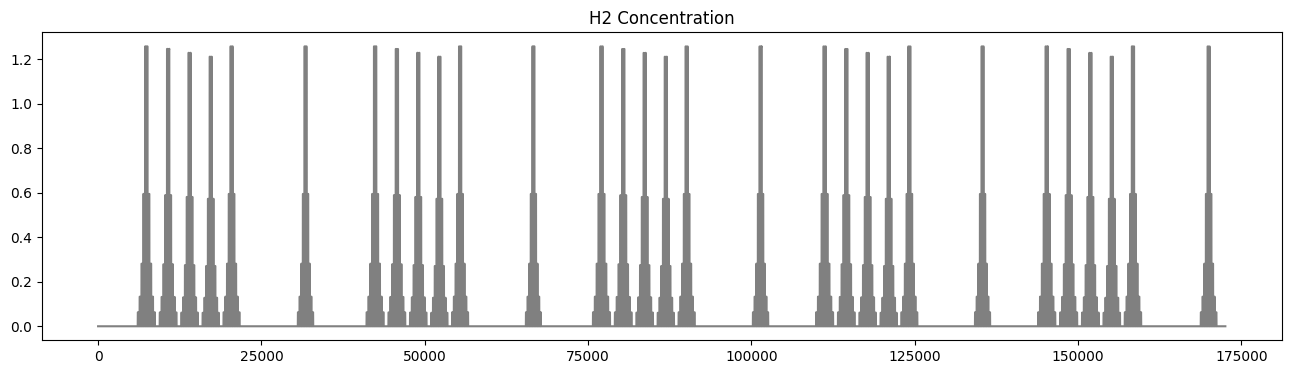

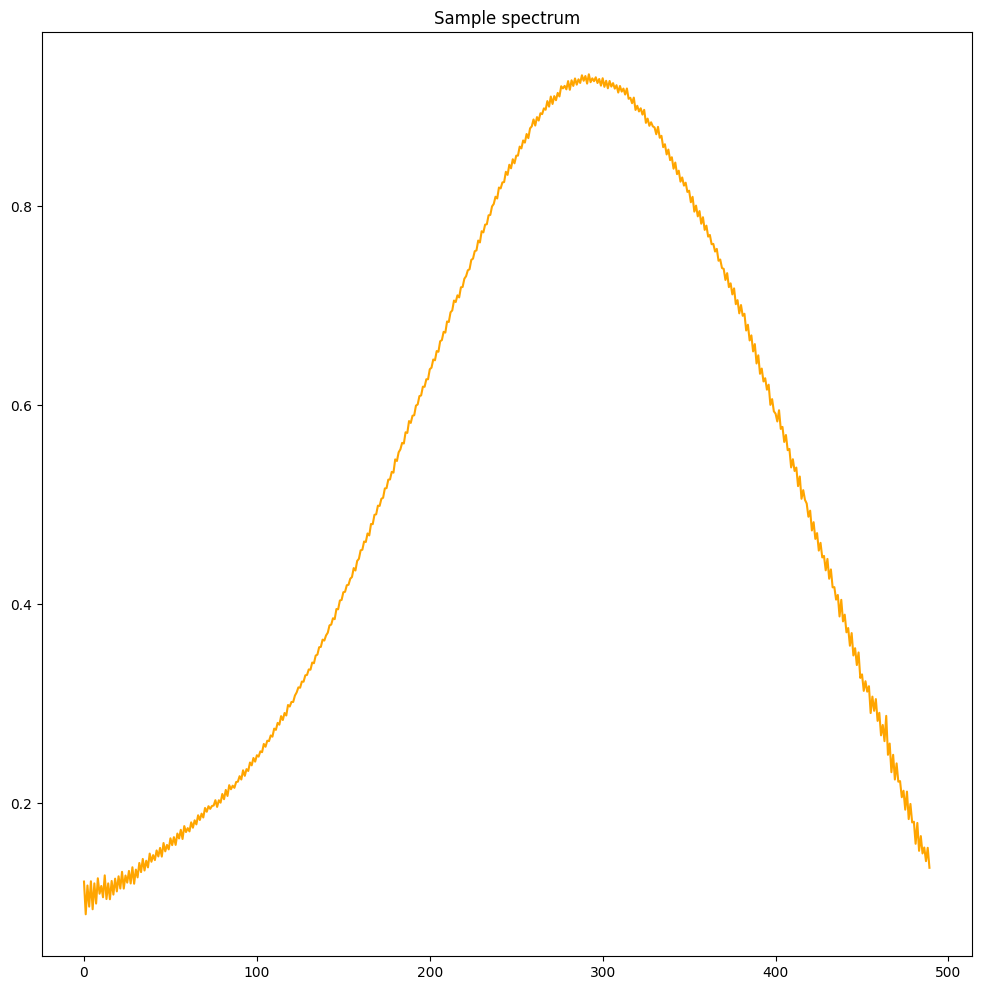

In [8]:

def read_txt(path):
    data = np.loadtxt(path, skiprows=16, usecols=[0,2,3,4,5])
    return data

def shape_data(data, time_steps):
    data = np.reshape(data, (data.shape[0] // time_steps, time_steps, -1))
    return data

def normalize(data):
    # Normalize data
    
    minimum = np.min(data[:100,...])
    data=data-minimum
    maximum=np.max(data[:100,...])
    data=data/maximum
    
    minimum = np.min(data)
    data=data-minimum
    maximum=np.max(data)
    data=data/maximum
    return data

def normalize_full(sig,targ):
    # Normalize full loaded dataset
    minimum = np.min(sig)
    sig=sig-minimum
    maximum = np.max(sig)
    sig=sig/maximum
    
    minTarg = np.min(targ)
    targ=targ-minTarg
    maxTarg=np.max(targ)
    targ=targ/maxTarg
    return sig,targ,(minTarg,maxTarg)


def remove_outliers(target, MFC_input):
    # Remove outliers from target
    input_sum = MFC_input[:,1]
    target[input_sum == 0, 0] = 0
    start_indices_diff = np.diff(input_sum)
    start_indices = np.where(start_indices_diff > 0)[0]
    end_indices = np.where(start_indices_diff < 0)[0]

    for start, end in zip(start_indices, end_indices):
        target[start:end] = np.median(target[start:end])
    return target


def start_from_zero(signal, target, MFC_input=None, signal_ch2=None):
    #Synchronize signal and target
    signal_start = signal.iloc[0].name
    target_start = target.iloc[0][0]
    target_end = target.iloc[-1][0]

    time_signal = np.array(signal.index)
    time_target = np.array(target['Hydrogen concentration (%)'].keys())
    
    # Correct for summer time shift
    time_diff = np.diff(time_signal)
    if np.max(time_diff) > 3600:
        ind = np.argmax(time_diff)
        time_signal[ind+1:] -= 3600

    time_signal -= signal_start
    time_target = time_target-signal_start

    signal = np.array(signal)
    if signal_ch2 is not None:
        signal_ch2 = np.array(signal_ch2)
    target = np.array(target)
    if MFC_input is not None:
        MFC_input = np.array(MFC_input)
    
    signal = signal[time_signal > target_start]
    if signal_ch2 is not None:
        signal_ch2 = signal_ch2[time_signal > target_start]
    time_signal = time_signal[time_signal > target_start]
    
    signal = signal[time_signal < target_end]
    if signal_ch2 is not None:
        signal_ch2 = signal_ch2[time_signal < target_end]
    time_signal = time_signal[time_signal < target_end]
    
    synced_target = np.ones((signal.shape[0], 1)) * 10000
    synced_input = np.ones((signal.shape[0], 4)) * 10000
    for i, t in enumerate(time_signal):
        try:
            sync_time = np.where(time_target - t > 0)[0][0]
            synced_target[i, 0] = target[sync_time, 1]
            if MFC_input is not None:
                synced_input[i, :] = MFC_input[sync_time, 1:]
        except IndexError:
            break
        
    return signal, synced_target, synced_input, signal_ch2



# Initialize variables
time_steps = 50
num_folders = len(folders)
get_dfs = np.arange(0, num_folders)
generator = 0
normalize_by_window = 0

# Delete variables if they exist
for var in ['signals', 'targets', 'MFC_inputs']:
    if var in locals():
        del locals()[var]

# Loop through each dataframe
for i in get_dfs:
    signal = dataframes[i]["signal"]
    target = dataframes[i]["target"]
    MFC_input = dataframes[i]["input"]

    signal, target, MFC_input, signal_ch2 = start_from_zero(signal, target, MFC_input)

    signal = signal[:, 10:500]
    signal = normalize(signal)

    ind1 = 4000
    ind2 = -1

    target = target[ind1:ind2]
    signal = signal[ind1:ind2]
    MFC_input = MFC_input[ind1:ind2]
    target = remove_outliers(target, MFC_input)

    signals = np.append(signals, signal, 0) if 'signals' in locals() else signal
    targets = np.append(targets, target, 0) if 'targets' in locals() else target
    MFC_inputs = np.append(MFC_inputs, MFC_input, 0) if 'MFC_inputs' in locals() else MFC_input

# Normalize full signals and targets
signals, _, constant = normalize_full(signals, targets)
wvls = signals.shape[-1]

# Plot the targets and signals
plt.figure(figsize=(16,4))
plt.plot(targets[:,0],c="gray")
plt.title("H2 Concentration")
plt.figure(figsize=(12,12))
plt.plot(signals[0,:].T,c="orange")
plt.title("Sample spectrum")

Text(0.5, 1.0, 'Peaks used for testing')

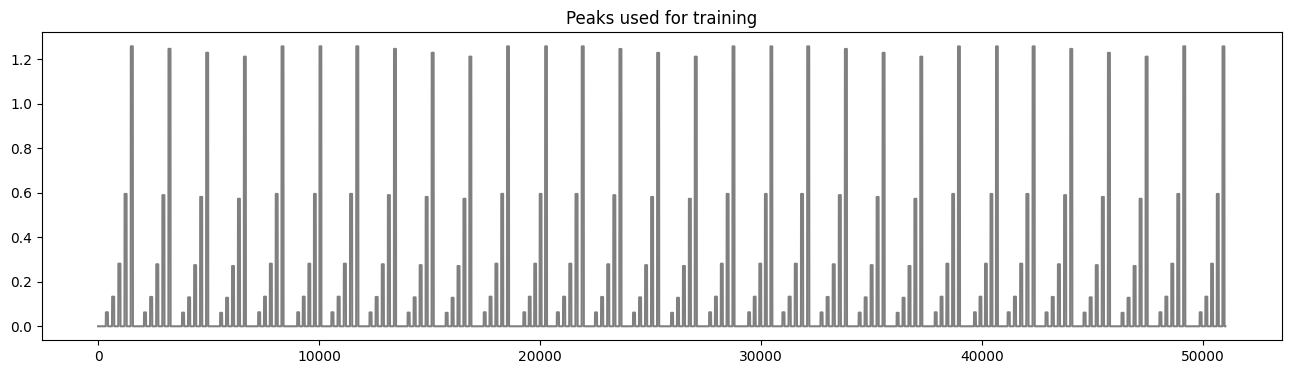

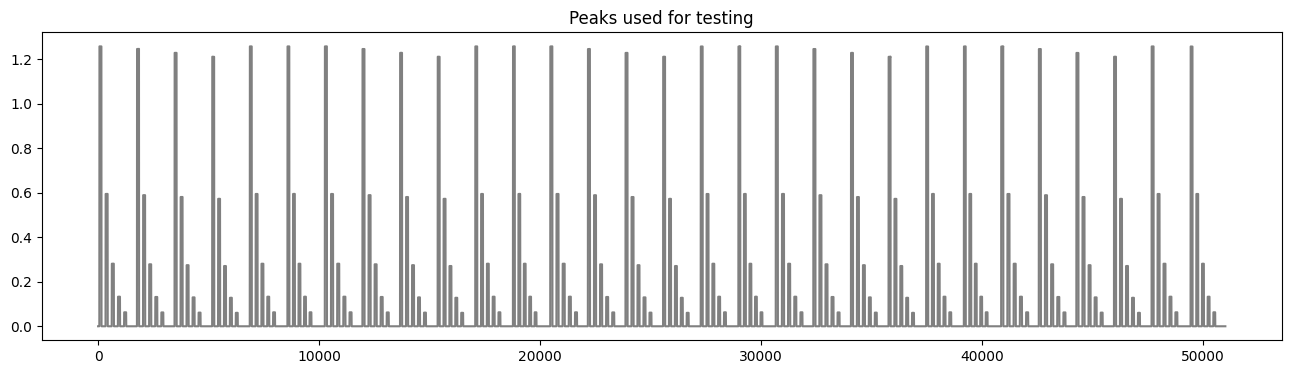

In [9]:
# Split data-set

#Get MFC input for H2 pulses
input_sum = MFC_inputs[:, 1]
plt.figure(figsize=(16,4))
plt.plot(input_sum, c="gray")
plt.title("MFC input")

# Get the unique top pressure indices and start indices of the pulses
top_pressure_indices = np.unique(input_sum)
start_indices = np.where(input_sum == top_pressure_indices[-1])[0]
start_indices_diff = np.diff(start_indices)
start_indices_diff = np.where(start_indices_diff > 1000)
start_indices = start_indices[start_indices_diff] - 150
start_indices = np.append(start_indices, 169950)

# Initialize test and train indices
test_indices = []
train_indices = []

# Loop through each start index
for i in range(len(start_indices)):
    test_indices = np.append(test_indices, np.arange(start_indices[i], start_indices[i] + 1700))
    train_indices = np.append(train_indices, np.arange(start_indices[i] - 1700, start_indices[i]))

# Convert  indices to integers
test_indices = [int(v) for v in test_indices]
train_indices = [int(v) for v in train_indices]

# Plot the targets for test and train indices
plt.figure(figsize=(16,4))
plt.plot(targets[train_indices, 0],c="gray")
plt.title("Peaks used for training")
plt.figure(figsize=(16,4))
plt.plot(targets[test_indices, 0],c="gray")
plt.title("Peaks used for testing")

In [10]:

# Define the DataGeneratorPredict class
class DataGeneratorPredict(Sequence):
    def __init__(self, x, y, batch_size, seq_len):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.seq_len = seq_len

    def __len__(self):
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        x = self.x[index * self.batch_size:(index + 1) * self.batch_size]
        y = self.y[index * self.batch_size:(index + 1) * self.batch_size]
        return np.array(x), np.array(y)

class ConvTransformer(keras.Model):
    def __init__(self, input_shape, num_heads, ff_dim, num_t_layers, num_dense_layers, dropout_rate):
        super(ConvTransformer, self).__init__()
        
        self.embedding = layers.Conv1D(filters=input_shape[1], kernel_size=1, padding="same")
        self.pos_embedding = PositionEmbedding(input_shape[1])
        self.pos_embedding = SinePositionEncoding()
        self.transformer_blocks = [TransformerBlock(num_heads, ff_dim, num_dense_layers) for _ in range(num_t_layers)]
        self.dropout = layers.Dropout(dropout_rate)
        self.pooling = layers.Flatten()
        self.norm_layer = layers.BatchNormalization()
        
        self.final_layer = layers.Dense(1, activation="leaky_relu")
        
    def call(self, inputs):
        x = self.norm_layer(inputs)
        x = self.embedding(x)
        positions = self.pos_embedding(x)
        x += positions
        x = self.dropout(x)
        for transformer in self.transformer_blocks:
            x = transformer(x)
        x = self.pooling(x)
        x = self.final_layer(x)
        return x
        
class ResidualDenseSequence(keras.Model):
    def __init__(self, num_layers, units):
        super(ResidualDenseSequence, self).__init__()
        self.num_layers = num_layers
        self.units = units
        self.dense_layers = []
        for i in range(num_layers):
            self.dense_layers.append(keras.Sequential([
                layers.BatchNormalization(),
                layers.Dense(units, activation="leaky_relu"),
                layers.Dense(units, activation="leaky_relu"),
                layers.Dense(input_shape[1], activation="leaky_relu"),
                layers.Dropout(0)
            ]))
        
    def call(self, inputs):
        x = inputs
        for i in range(self.num_layers):
            residual = x    
            x = self.dense_layers[i](x)
            if i != self.num_layers - 1:
                x = layers.add([x, residual])
        return x

class TransformerBlock(keras.Model):
    def __init__(self, num_heads, ff_dim, num_layers):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)
        self.ffn = ResidualDenseSequence(num_layers=num_layers, units=ff_dim)
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0)
        self.dropout2 = layers.Dropout(0)
        
    def call(self, inputs):
        x = inputs
        attn_output = self.att(x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layer_norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layer_norm2(out1 + ffn_output)
    
seqLen = 4
batch_size=8192
input_shape = (seqLen, wvls)
num_heads = 8
ff_dim = 512
num_t_layers = 1
num_dense_layers=3
model = ConvTransformer(input_shape, num_heads, ff_dim, num_t_layers, num_dense_layers,dropout_rate=0)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.1)

model.compile(loss='mae', optimizer=Adam(lr=1e-5), metrics=['accuracy']) 
model.predict(np.zeros((batch_size,seqLen,wvls)))

# Define the training and validation data generators
train_gen = DataGeneratorPredict(signals[train_indices], targets[train_indices], batch_size, seqLen)
val_gen = DataGeneratorPredict(signals[test_indices], targets[test_indices], batch_size, seqLen)

# Define the early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3000)

# Train the model
history = model.fit(train_gen, epochs=0, validation_data=val_gen, callbacks=[early_stopping])

# Plot the training and validation loss
try:
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
except:
    pass

c:\Users\ccx55\anaconda3\envs\nn_h2sensing\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


256/256 [==============================] - 4s 3ms/step


<Figure size 640x480 with 0 Axes>

17/17 [==============================] - 1s 5ms/step


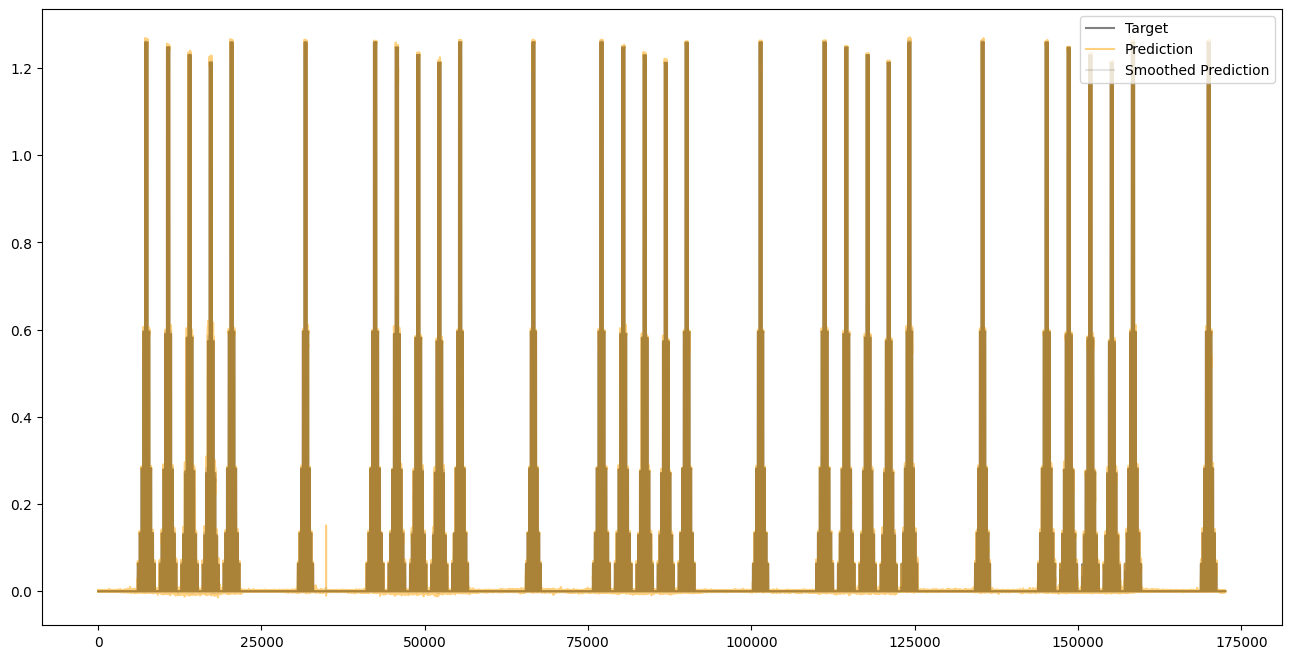

In [12]:
model.load_weights("weights/ConvTransformers_4_8192_posembed.h5")

# Define the full data generator
full_gen = TimeseriesGenerator(
    signals, 
    targets, 
    length=seqLen, 
    stride=1, 
    batch_size=batch_size,
    shuffle=False
)

pred_full = []
tar_full = []
counter = 0

# Generate predictions for the full dataset
for i in range(len(full_gen)):
    counter += 1
    sig, tar = full_gen[i]
    pred = model.predict(sig)
    pred_full = np.append(pred_full, np.array(pred).flatten(), 0)
    tar_full = np.append(tar_full, np.array(tar).flatten(), 0)

pred_full = pred_full.reshape(-1, 1)

# Plot the predictions and targets
plt.figure(figsize=(16,8))
plt.plot(tar_full.flatten(),label="Target",c="gray")
plt.plot(np.array(pred_full).flatten(), alpha=0.5,label="Prediction",c="orange")
# Smooth the predictions and plot again
smooth_pred = pd.DataFrame(pred_full.flatten()).rolling(20).mean()
plt.plot(smooth_pred, alpha=0.1,label="Smoothed Prediction",c="black")
plt.legend(loc="best")

Experiment 0
Experiment 1
Experiment 2
Experiment 3
Experiment 4


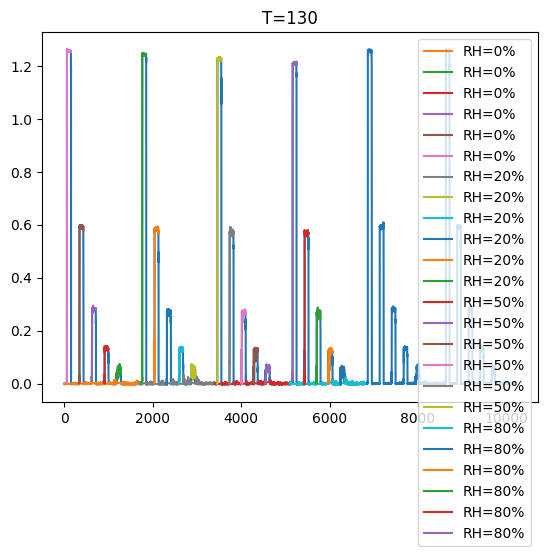

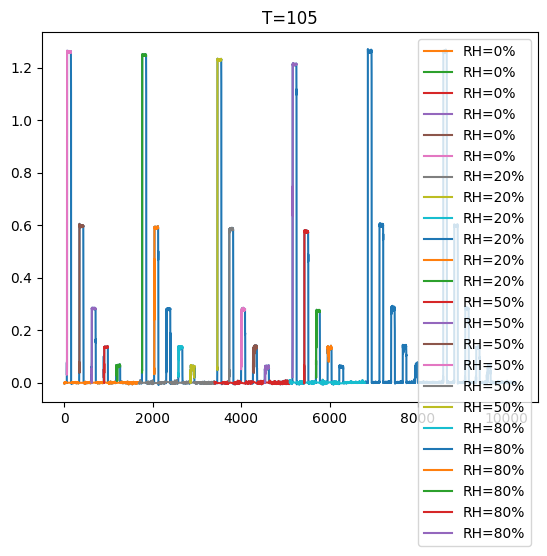

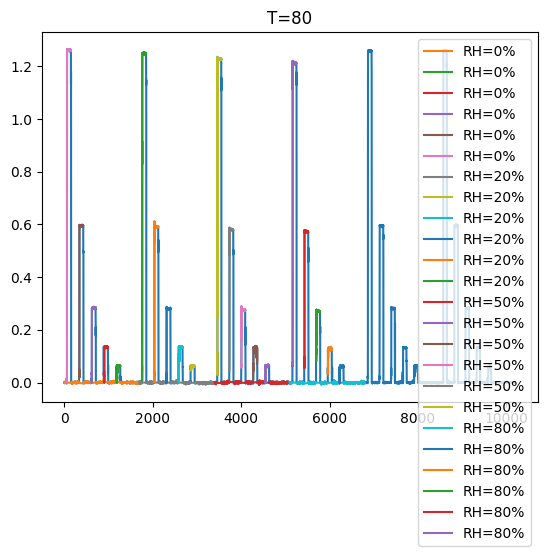

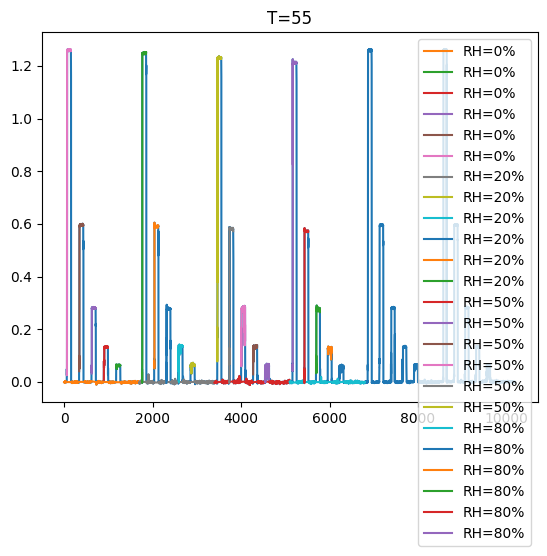

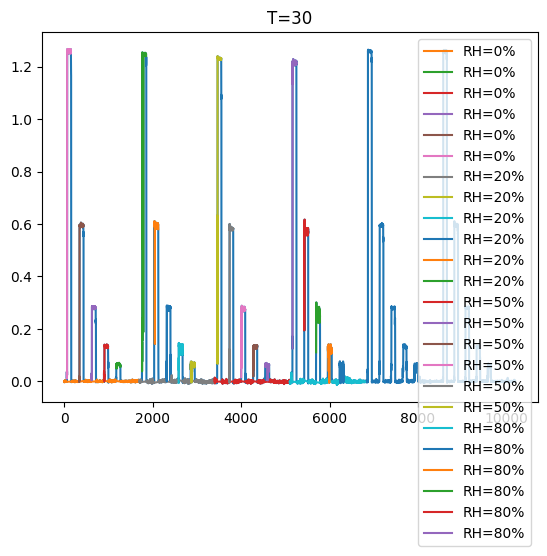

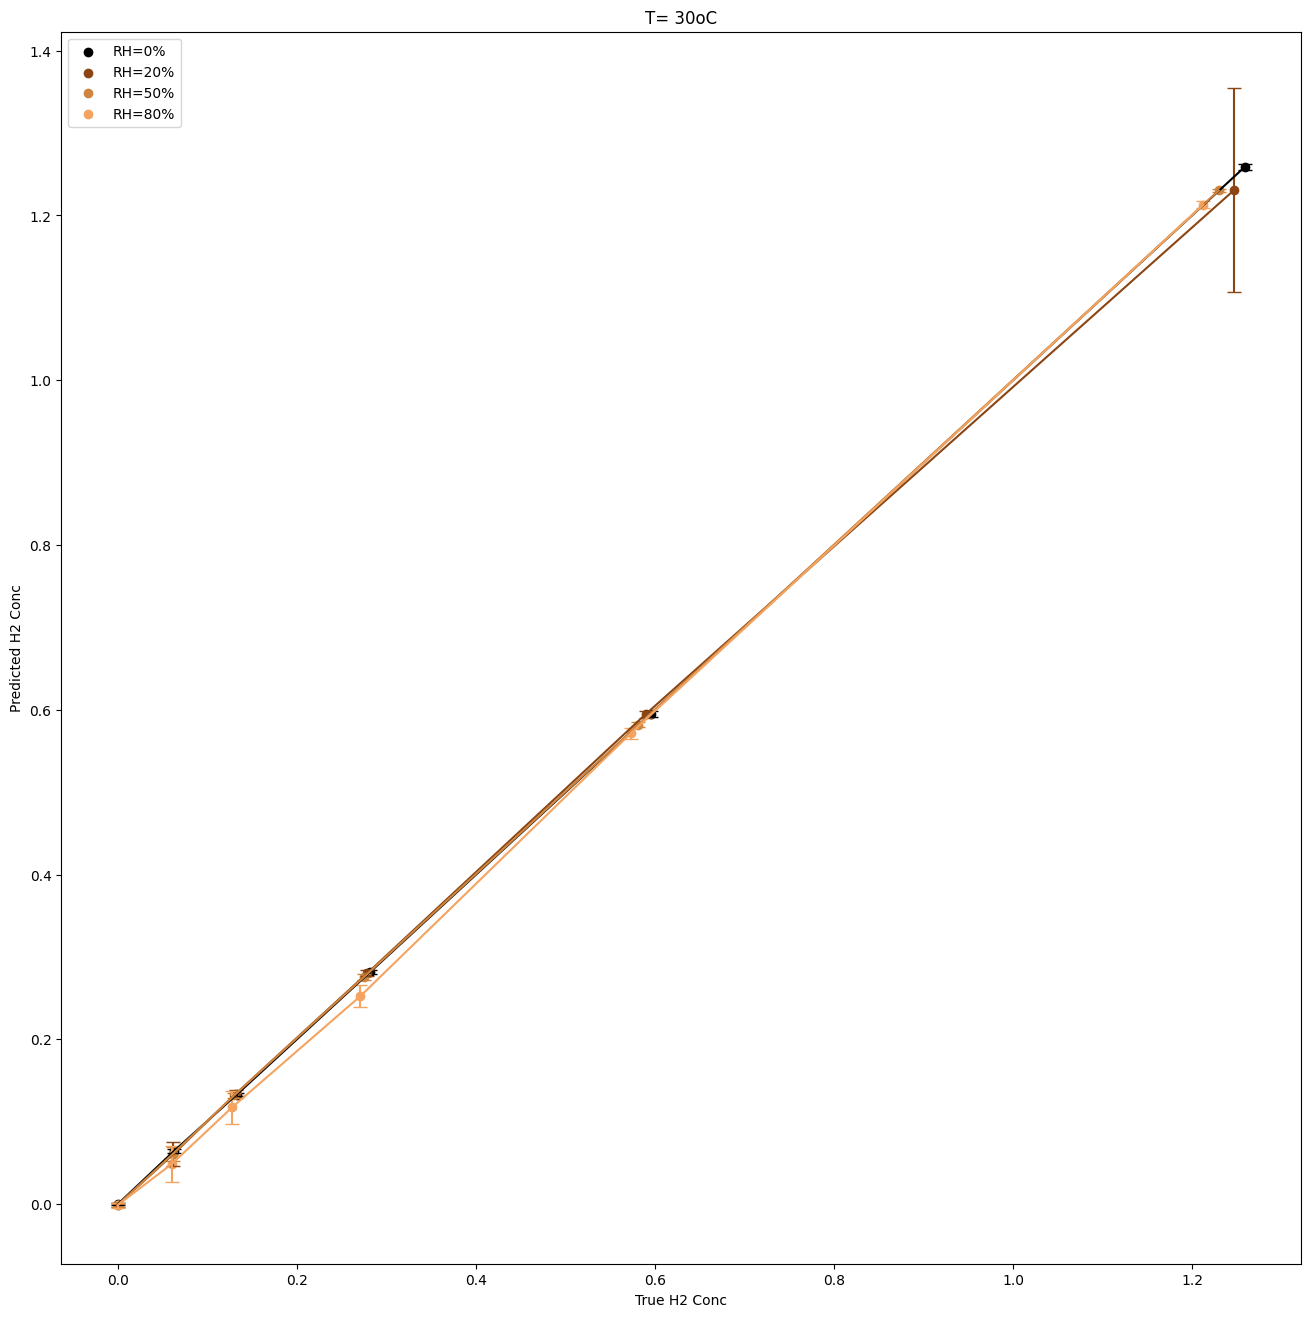

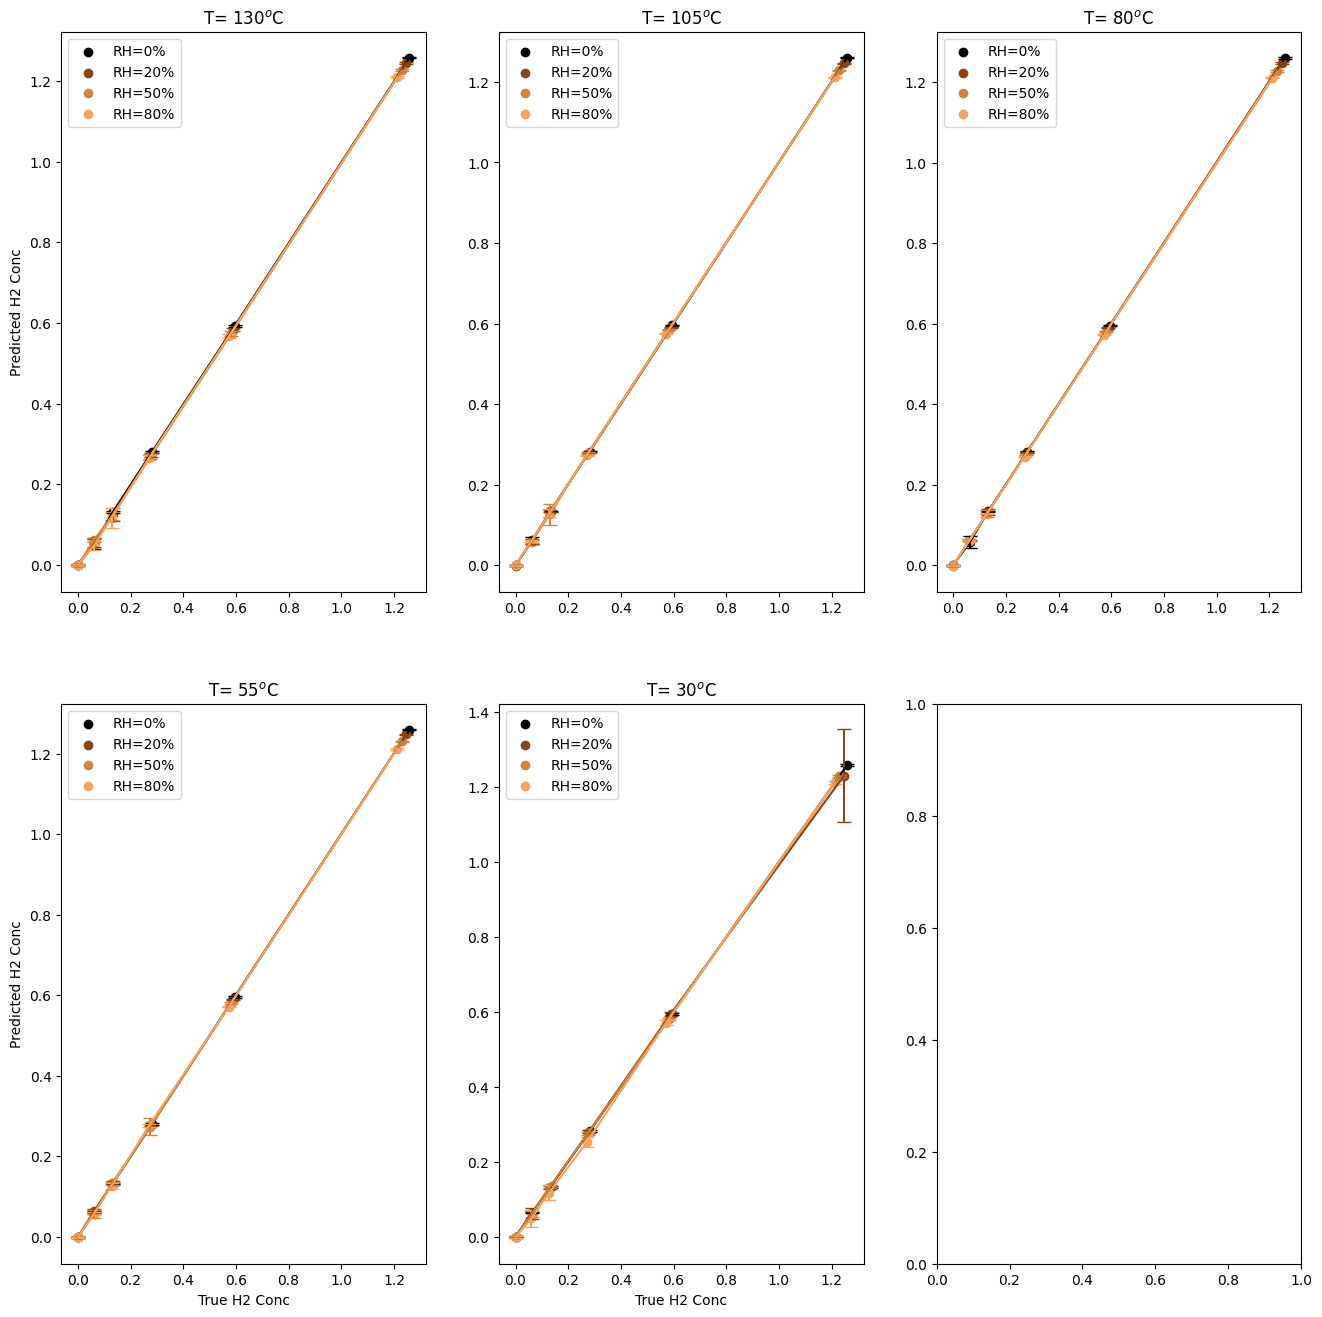

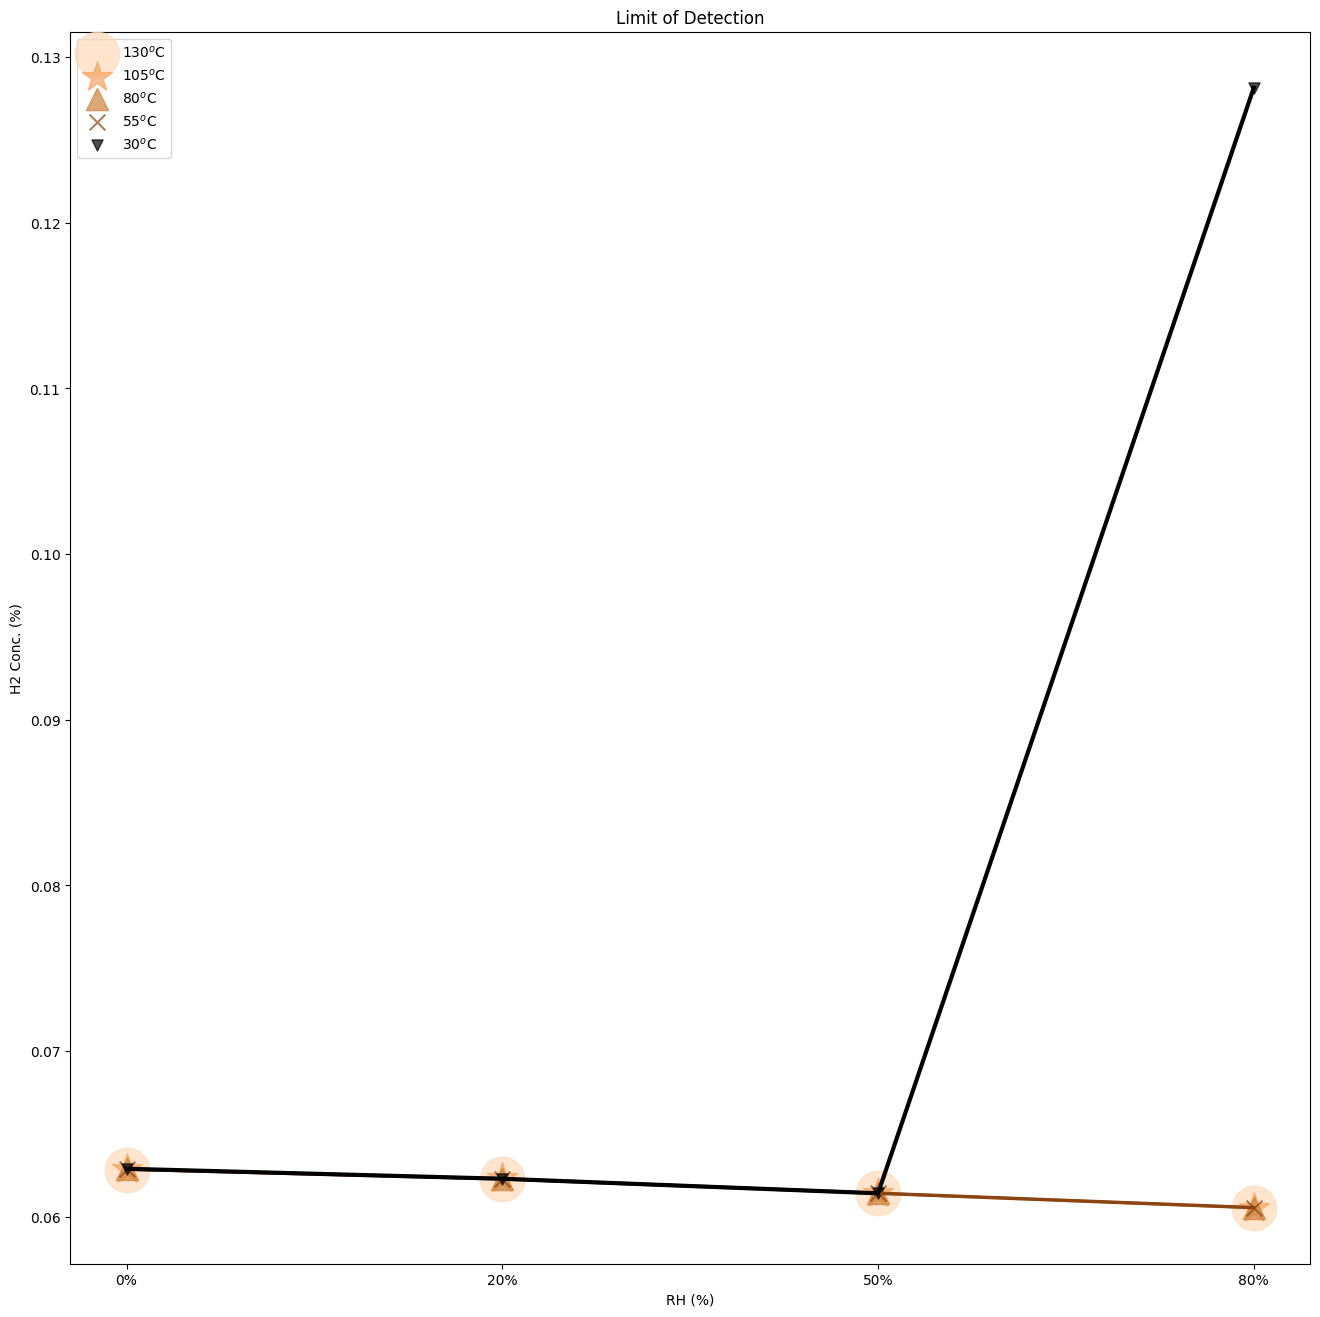

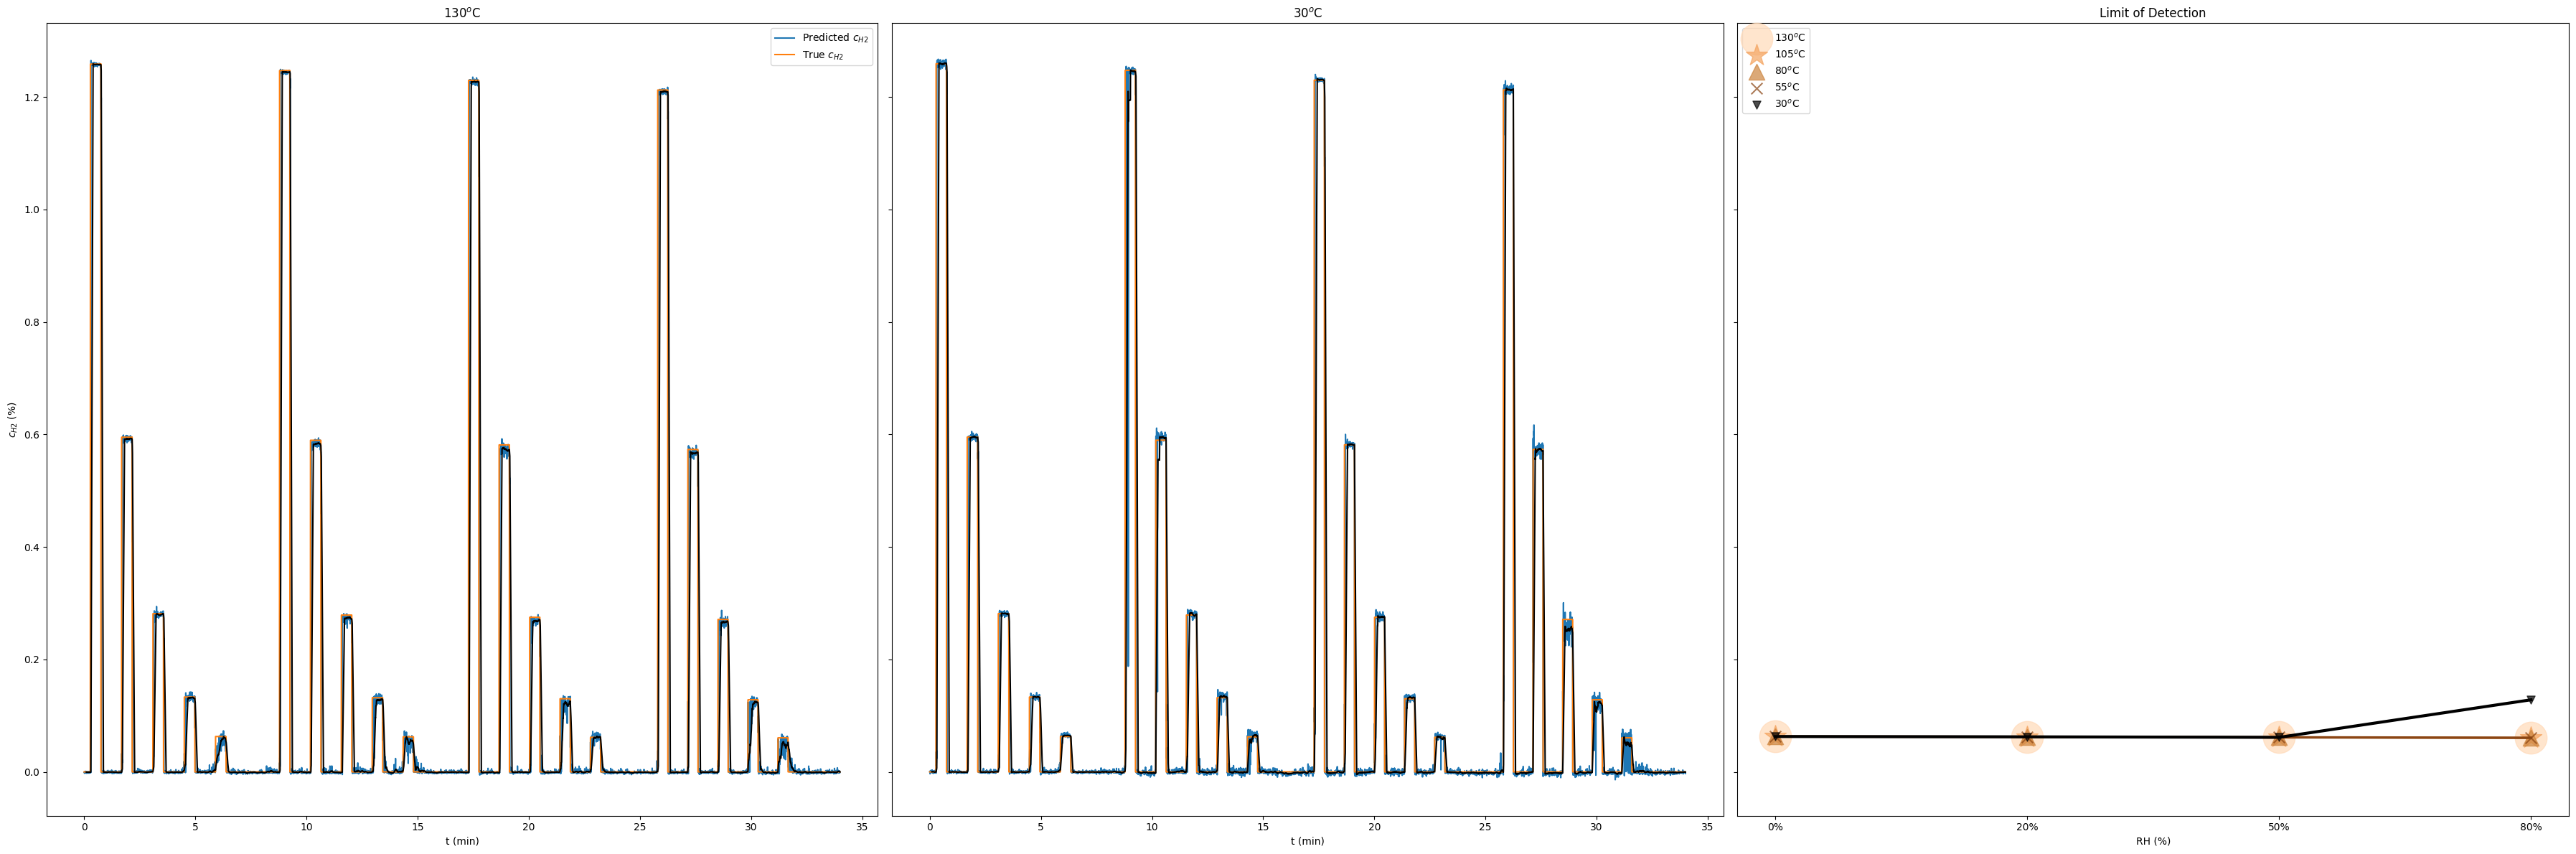

In [13]:
#Quantify LoD

def get_mean_pred(pred, indices_cutoff=30):
    pred = pred[indices_cutoff:-5]
    return np.mean(pred), np.std(pred)

plt.close('all')
indices_cutoff = 15
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
humidity_labels = ["0%", "20%", "50%", "80%", "0%-2", "0%-check"]
temperatures = ["130", "105", "80", "55", "30"]
input_sum = MFC_inputs[:, 1]
top_pressure_indices = np.unique(input_sum)

start_indices = np.where(input_sum == top_pressure_indices[-1])[0]
start_indices_diff = np.diff(start_indices)
start_indices_diff = np.where(start_indices_diff > 1000)
start_indices = start_indices[start_indices_diff] - 150
start_indices = np.append(start_indices, 169950)

test_indices = []
train_indices = []
num_peaks = 6
num_experiments = 5
num_humidities = 4
humidity_labels = humidity_labels[:-2]
mean_pred_per_peak = np.zeros((num_peaks, num_experiments, num_humidities))
std_pred_per_peak = np.zeros((num_peaks, num_experiments, num_humidities))
mean_target_per_peak = np.zeros((num_peaks, num_experiments, num_humidities))

for j in range(num_experiments):
    print(f"Experiment {j}")
    test_indices = []
    train_indices = []
    for i in range(len(start_indices) - max(0, 6 * (j + 1)), len(start_indices) - (6 * j)):
        test_indices = np.append(test_indices, np.arange(start_indices[i], start_indices[i] + 1700))
        train_indices = np.append(train_indices, np.arange(start_indices[i] - 1700, start_indices[i]))

    test_indices = [int(v) for v in test_indices]
    train_indices = [int(v) for v in train_indices]
    train_indices = test_indices
    current_experiment_peaks = input_sum[train_indices]

    plt.figure(j)
    plt.plot(pred_full[train_indices])

    for l in range(num_humidities):
        current_peaks = current_experiment_peaks[l * int(current_experiment_peaks.shape[0] / 6):(l + 1) * int(current_experiment_peaks.shape[0] / 6)]
        unique_peaks = np.unique(current_peaks)

        for k in range(len(unique_peaks)):
            unique_indices = np.where(current_peaks == unique_peaks[k])[0] + int(current_experiment_peaks.shape[0] / 6 * l)

            if k == 0:
                inds = np.where(np.diff(unique_indices) > 1)[0]
                indices_to_delete = [0]
                for ind in inds:
                    indices_to_delete = np.append(indices_to_delete, np.arange(ind - indices_cutoff, ind + indices_cutoff))
                unique_indices = np.delete(unique_indices, indices_to_delete[1:])

            pred_current_peak = pred_full[train_indices][unique_indices]
            mean_pred, std_pred = get_mean_pred(pred_current_peak, indices_cutoff=indices_cutoff)
            mean_target = np.mean(targets[train_indices][unique_indices])

            plt.figure(j)
            plt.title(f"T={temperatures[j]}")
            plt.plot(unique_indices, pred_current_peak, label=f"RH={humidity_labels[l]}")

            mean_pred_per_peak[k, j, l] = mean_pred
            std_pred_per_peak[k, j, l] = std_pred
            mean_target_per_peak[k, j, l] = mean_target

    plt.legend(loc="best")
import pandas as pd

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
mean_target_per_peak_scaled = np.copy(mean_target_per_peak)
mean_pred_per_peak_scaled = np.copy(mean_pred_per_peak)

lod = np.array((mean_pred_per_peak_scaled - 3 * std_pred_per_peak) > 0)
lod = np.append(np.array([False] * num_experiments * num_humidities).reshape(1, num_experiments, num_humidities), lod, 0)
target_lod = np.append(mean_target_per_peak, np.array([0] * num_experiments * num_humidities).reshape(1, num_experiments, num_humidities), 0)
lod_array = target_lod * ~lod
lod_array = lod_array[1:, ...]
lod_continuous = np.array((mean_pred_per_peak_scaled - 3 * std_pred_per_peak))
lod_continuous = np.append(lod_continuous, np.array([0] * num_experiments * num_humidities).reshape(1, num_experiments, num_humidities), 0)
lod_continuous = lod_continuous * ~lod

humidity_labels = ["0%", "20%", "50%", "80%", "0%-2", "0%-check"]
color_list = ["black", "black", "saddlebrown", "peru", "sandybrown", "black", "black"]
color_list_experiments = ["peachpuff", "sandybrown", "peru", "saddlebrown", "black"]
marker_list = ["o", "*", "^", "x", "v"]

fig, axs = plt.subplots(2, 3, figsize=(16, 16))
axs = axs.flatten()

for j in range(0, num_experiments):
    ax = axs[j]
    for i in range(0, num_humidities):
        ax.scatter(mean_target_per_peak[:, j, i], mean_pred_per_peak_scaled[:, j, i], label="RH=" + humidity_labels[i], c=color_list[1 + i])
        ax.errorbar(mean_target_per_peak[:, j, i], mean_pred_per_peak_scaled[:, j, i], yerr=std_pred_per_peak[:, j, i], c=color_list[1 + i], capsize=5)
    ax.legend(loc="best")
    ax.set_title("T= " + temperatures[j] + "$^o$C")
    if j > 2:
        ax.set_xlabel("True H2 Conc")
    if j == 0 or j == 3:
        ax.set_ylabel("Predicted H2 Conc")

plt.figure(figsize=(16, 16))

for i in range(0, num_humidities):
    plt.scatter(mean_target_per_peak[:, j, i], mean_pred_per_peak_scaled[:, j, i], label="RH=" + humidity_labels[i], c=color_list[1 + i])
    plt.errorbar(mean_target_per_peak[:, j, i], mean_pred_per_peak_scaled[:, j, i], yerr=std_pred_per_peak[:, j, i], c=color_list[1 + i], capsize=5)

plt.legend(loc="best")
plt.title("T= " + temperatures[j] + "oC")
plt.xlabel("True H2 Conc")
plt.ylabel("Predicted H2 Conc")

plt.figure(fig)
plt.figure(figsize=(16, 16))
max_lod = np.max(lod_array, 0)

for j in range(0, num_experiments):
    plt.scatter(["0%", "20%", "50%", "80%"], max_lod[j, ...], c=color_list_experiments[j], s=1024 / (2 ** j), label=temperatures[j] + "$^o$C", marker=marker_list[j], alpha=0.7)
    plt.plot(["0%", "20%", "50%", "80%"], max_lod[j, ...], c=color_list_experiments[j], linewidth=1 + 0.5 * j)

plt.xlabel("RH (%)")
plt.ylabel("H2 Conc. (%)")
plt.title("Limit of Detection")
plt.legend(loc="best")

fig, axs = plt.subplots(1, 3, figsize=(36, 12), sharey=True, tight_layout=True)

for j in [0, 4]:
    test_indices = []
    for i in range(len(start_indices) - np.max([0, 6 * (j + 1)]), len(start_indices) - (6 * j) - 2):
        test_indices = np.append(test_indices, np.arange(start_indices[i], start_indices[i] + 1700))
        test_indices = [int(v) for v in test_indices]
    pred = pred_full[test_indices]
    time_array = np.linspace(0, len(test_indices) * 0.3 / 60, len(test_indices))
    avg_pred = pd.DataFrame(pred).rolling(20).mean().to_numpy()
    avg_std = pd.DataFrame(pred).rolling(20).std().to_numpy()

    if j == 0:
        axs[0].plot(time_array, pred, label="Predicted $c_{H2}$")
        axs[0].plot(time_array, targets[test_indices], label="True $c_{H2}$")
        axs[0].plot(time_array, avg_pred, c="black")
    else:
        axs[1].plot(time_array, pred)
        axs[1].plot(time_array, targets[test_indices])
        axs[1].plot(time_array, avg_pred, c="black", label="Rol. Avg.")

axs[0].set_xlabel("t (min)")
axs[0].set_ylabel("$c_{H2}$ (%)")
axs[0].set_title("130$^o$C")
axs[0].legend(loc="upper right")
axs[1].set_xlabel("t (min)")
axs[1].set_title("30$^o$C")

for j in range(0, num_experiments):
    axs[2].scatter(["0%", "20%", "50%", "80%"], max_lod[j, ...], c=color_list_experiments[j], s=1024 / (2 ** j), label=temperatures[j] + "$^o$C", marker=marker_list[j], alpha=0.7)
    axs[2].plot(["0%", "20%", "50%", "80%"], max_lod[j, ...], c=color_list_experiments[j], linewidth=1 + 0.5 * j)

axs[2].set_xlabel("RH (%)")
axs[2].set_title("Limit of Detection")
axs[2].legend(loc="upper left")